#Using Gaussian Realizations of the density Field $\delta (\vec{x})$ to generate Maps of multi-tracers Galaxies 



### *Arthur E. M. Loureiro* 

### **18/07/2014**

###***IFUSP***

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import grid3D as gr
import sys
from time import time
from scipy import interpolate
import pylab as pl
from matplotlib import cm
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
import fkp_class as fkpc
import gauss_pk_class as pkgauss
from input import * 
from selection_function import *
#from mpl_toolkits.mplot3d.axes3d import Axes3D

Reading **Camb's** file
$P(k=0)=0$

In [3]:
k_camb , Pk_camb = np.loadtxt(camb_file, unpack=True)
k_camb = np.insert(k_camb,0,0.)						
Pk_camb = np.insert(Pk_camb,0,0.)

Calculating $V_{box}$ and generating the Grids

Generating the k-space Grid...



<matplotlib.colorbar.Colorbar instance at 0x116c61b00>

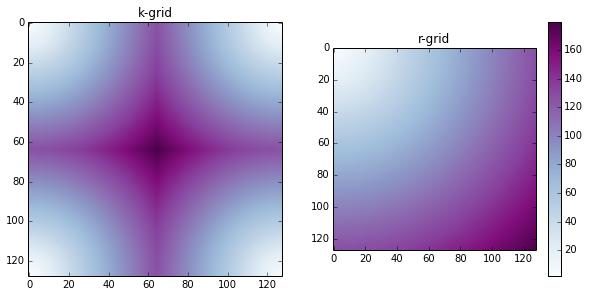

In [4]:
L_x = n_x*cell_size ; L_y = n_y*cell_size ; L_z = n_z*cell_size 		     # size of the box
box_vol = L_x*L_y*L_z								     # Box's volume
L_max = np.sqrt(L_x*L_x + L_y*L_y + L_z*L_z)	

print("Generating the k-space Grid...\n")
grid = gr.grid3d(n_x,n_y,n_z,L_x,L_y,L_z)					     # generates the grid

pl.figure(figsize=(10,10))
pl.subplot(2,2,1)
pl.title("k-grid")
pl.imshow(grid.grid_k[2],cmap=cm.BuPu)
pl.subplot(2,2,2)
pl.title("r-grid")
pl.imshow(grid.grid_r[2],cmap=cm.BuPu)
pl.colorbar()


In [5]:
np.amax(grid.grid_k)*(2.*np.pi*n_x/L_x)

0.69649895586593968

This will be used to calculate $P_G(k)$ using a $k_{step} = \frac{1}{(1.1) L_{max}}$, $k_{max} = \frac{2\pi}{L_{cell}} $ where $L_{max} = \sqrt{L_x^2 + L_y^2 + L_z^2}$ is the diagonal of the box

Calculating $P_G(k)$

In [6]:
%%time
pkg = pkgauss.gauss_pk(k_camb,Pk_camb,grid.grid_k,cell_size,L_max)

CPU times: user 108 ms, sys: 28.9 ms, total: 137 ms
Wall time: 137 ms


Finding $\xi_{camb}(r) = \int dk ... P(k)sin(kr)/k$

Ploting $\xi_{camb}(r)$ in a limited useful range

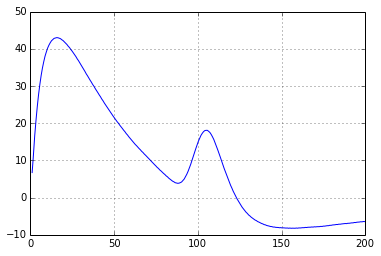

In [7]:
pl.figure()
pl.grid(1)
pl.xlim(0,200)
pl.plot(pkg.r_k,(pkg.r_k*pkg.r_k)*pkg.corr_ln)

This plot shows both $P_{camb}(k)$, $P_{G}(k)$ and $P_{camb}(k)e^{-(k/2k_{max})^{-6}}$

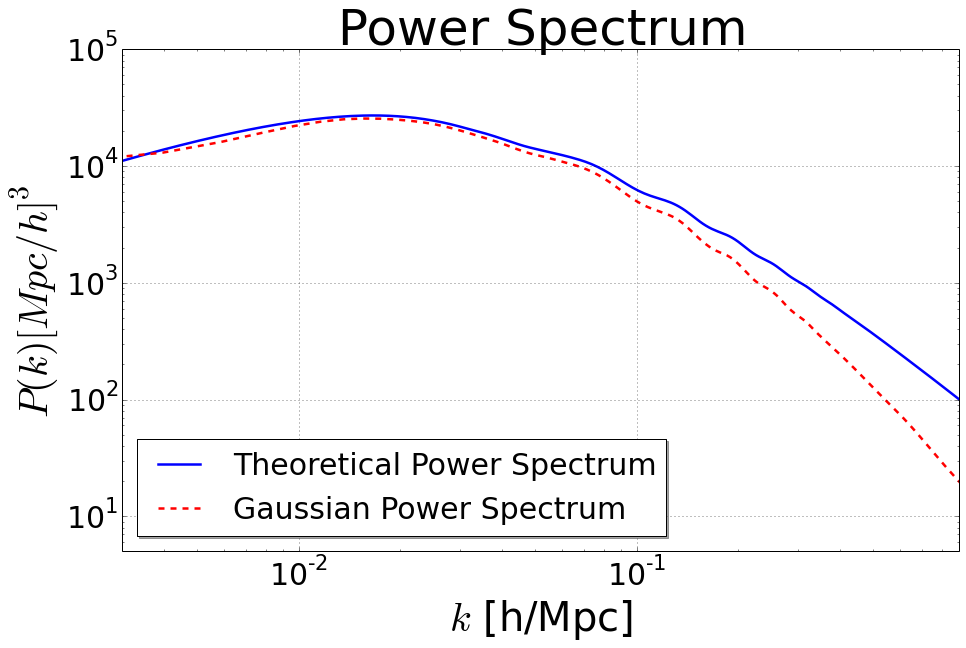

In [8]:
#pl.figure(figsize=(8,6))
pl.figure('P(k)',figsize=(15,9),dpi=500)
pl.loglog() 
pl.title("Power Spectrum",size=50)
pl.xlim(3E-3,.9)
pl.ylim(5E0,1E5)
pl.grid(1)
pl.plot(k_camb, pkg.Pk_camb_interp(k_camb), linewidth=2.5, label="Theoretical Power Spectrum")
#pl.plot(k_camb, pkg.Pk_camb_interp(k_camb)*np.exp(-1.0*np.power(k_camb/(3.*pkg.k_max),6.0)))
#pl.plot(k_r, Pk_gauss_interp(k_r),'--' ,linewidth=2.5)
pl.plot(pkg.k_r, pkg.Pk_gauss_interp(pkg.k_r),'--r' ,linewidth=2.5, label="Gaussian Power Spectrum")
#pl.axvline(x=np.max(grid.grid_k), linewidth=2., color='r')
#pl.axvline(x=np.min(grid.grid_k[grid.grid_k!=0.0]), linewidth=2., color='g')
#pl.plot(k_r,Pk_gauss)
pl.legend(loc=0,prop={'size':30},shadow=1)
pl.xlabel(r'$k$ [h/Mpc]',fontsize=40)
pl.xticks(size=30)
pl.yticks(size=30)
pl.ylabel(r'$P(k) [Mpc/h]^3$',fontsize=40)
pl.savefig("gaussianPk.png")


In [9]:
%%time
k_flat = grid.grid_k.flatten()*(2.*np.pi*n_x/L_x)                 #this norm factor is so we can have physical unities
Pk_flat = pkg.Pk_gauss_interp(k_flat)
#print k_flat.reshape((n_x,n_y,n_z))==grid.grid_k
p_matrix = Pk_flat.reshape((n_x,n_y,n_z))
p_matrix[0][0][0] = 1. 						     # Needs to be 1.

CPU times: user 170 ms, sys: 17.5 ms, total: 188 ms
Wall time: 189 ms


Let us difine the **p.d.f.** s and some useful functions:

+ First, the **Gaussian Amplitude** with $\sigma_k = \sqrt{2P(k)V_{box}}$

+ $\mathbb{P}(A_k) = \frac{1}{\sigma_k}exp( -A_k^2/\sigma_k^2)$

+ Random regular phase $\mathbb{P}(\phi_k)$

+ The density constrast in Fourier Space $\delta_k = A_k e^{-i\phi}$

+ The Log-Normal density Field $\delta_{ln} = exp(b\delta_g - b^2\sigma_g/2) -1$

In [10]:
def test_selec(x,ep,gam,L):
    return 10*(1.+ep*np.tanh(gam*sin(x/L)))

# Selection Function parameters:
+ $L_s$ the ``board cell size''
+ $\epsilon$ controls the depth of the board cell
+ $\gamma$ controls the ``squareness'' of the board cell

In [11]:
Ls=(L_x/(20.*cell_size))
eps=1.0
gamm=0.5
print n_bar0,Ls

[10.0] 6.4


5.66858226086
[10.0]
7.8125 110


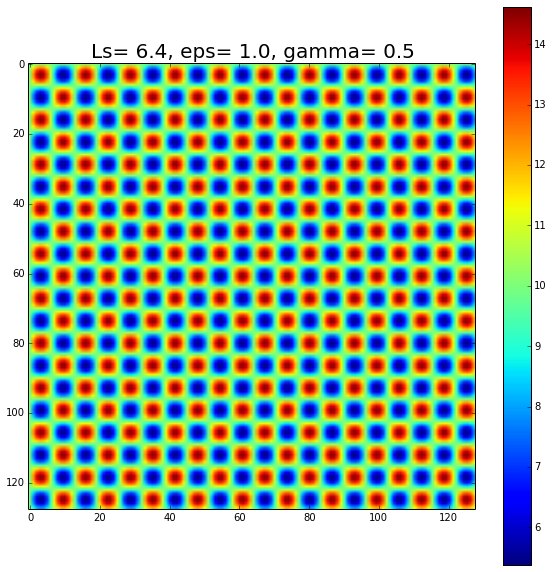

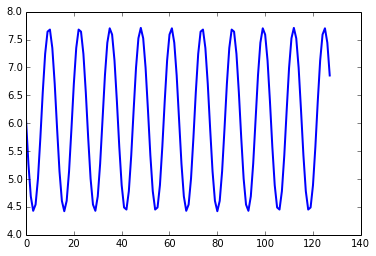

In [12]:
nn = int(np.sqrt(n_x**2 + n_y**2 + n_z**2))

r = np.linspace(0.,nn,64)
nmama = selection_func(grid.r_x,grid.r_y,grid.r_z,n_bar0[0],Ls,0.01,eps,gamm)

namefig = "FIG_"+str(int(Ls))+file_root+'_ep'+str(int(eps))+"gamm"+str(int(gamm))+".png"
pl.figure(figsize=(10,10))
pl.title("Ls= "+str(Ls)+", eps= "+str(eps)+", gamma= "+str(gamm),size=20)
pl.imshow(nmama[:,:,0])
pl.colorbar()
pl.savefig(namefig)
print np.mean(nmama)
#print selection_func(nn/2,n_bar0[0],0.002068,nn/2)
print n_bar0
print cell_size, nn/2
pl.figure()
#pl.plot(r,test_selec(r,1,10,30))
pl.plot(nmama[50,:,50],linewidth=2.0)

In [13]:
def A_k(P_):									 
	#################################################################################
	# The Gaussian Amplitude
	# Zero Medium and STD=SQRT(2*P(k)*Volume)
	# It must have the 2 factor to take the complex part into account after the iFFT
	#################################################################################
	return np.random.normal(0.0,np.sqrt(2.*P_*box_vol))	
def phi_k(P_): 									     	
	######################
	# Random regular phase
	######################
	return (np.random.random(len(P_)))*2.*np.pi	
def delta_k_g(P_):								     
	########################################	
	# The density contrast in Fourier Space
	########################################
	return A_k(P_)*np.exp(1j*phi_k(P_))	

In [14]:
def delta_x_ln(d_,sigma_,bias_):
	###############################
	# The log-normal density field
	###############################
	return np.exp(bias_*d_ - ((bias_**2.)*(sigma_))/2.0) -1.

##Now, the loops for $N_{real}$ and $N_{tracers}$
###Generates one $\delta_g (\vec{x})$ and use it to generate $N_{tracers}$ Log-Normal fields: $\delta_{LN}^1,\delta_{LN}^2, ...,\delta_{LN}^{N_{tracers}}  $ 
### Using Poissonian realizations, $\mathbb{P}_{pois}[\bar{n}^{trac}(\vec{x})(1+\delta_{LN}^{trac})] \longmapsto \delta_{gg}^{trac}(\vec{x})$

In [15]:
delta_xr = np.zeros((n_tracers,n_x,n_y,n_z))
n_bar_matrix = np.zeros((n_tracers,n_x,n_y,n_z))
N_r = np.zeros((n_tracers,n_x,n_y,n_z))

## New way Prof. Raul Abramo created to generate the $M_{ijl}^a$ Matrix

In [16]:
%%time
num_bins = 45

nn = int(np.sqrt(n_x**2 + n_y**2 + n_z**2))
kk_bar = np.fft.fftfreq(nn)
kmaxbar = np.sqrt(1.7)*np.max(abs(kk_bar))
dk0 = 2.0*np.min(kk_bar[np.where(kk_bar > 0)])
#R So, kmaxbar=0.68 is always the maximal frequency, in grid units (cell size=1)
#R But the maximal k should be the either k =~ 0.3 h/Mpc (non-linear scale),
#R or the kmaxbar above (in physical units), whichever is smallest.
if kmaxbar < cell_size*0.3/np.pi/2.0 :
    print('WARNING: max(k) < 0.3 h/Mpc for this grid! May be undersampling...\n')
else:
    print('Can compute P(k) up to k=', 2.0*np.pi*kmaxbar/cell_size, \
          'h/Mpc, but will stop at k=0.3 h/Mpc to save time/memory. \n')
kmaxbar=np.min((kmaxbar,cell_size*0.3/np.pi/2.0))
#R The number of bins should be set by the maximum k to be computed,
#R together with the minimum separation based on the physical volume.
#R Typically, dk =~ 1.4/L , where L is the typical size of the survey.
#R We can use dk =~ 1.5/n_x/(2 pi) (in grid units) to be conservative.
dk0=np.max((dk0,1.5/np.min((n_x,n_y,n_z))/(2.0*np.pi)))
num_bins=np.int(kmaxbar/dk0)
#R This line makes some np variables be printed with less digits
np.set_printoptions(precision=6)
#R Warning about k-binning
print('Will compute spectra up to k =', 2.0*np.pi*kmaxbar/cell_size , \
      'h/Mpc, in', num_bins , 'bins of dk =', 2.0*np.pi*dk0/cell_size, 'h/Mpc\n')

#R We should always use evenly spaced bins
dk_bar = dk0*np.ones(num_bins)
#R OR, use some definition like:
#dk_bar = kmaxbar/(num_bins + 0.0000000001)*np.ones(num_bins)

#R Here are the k's that will be estimated (in grid units):
k_bar = (dk_bar/1.99999) + np.linspace(0.,kmaxbar-dk0,num_bins)
kflat=np.ndarray.flatten(grid.grid_k[:,:,:n_z/2+1])
lenkf=len(kflat)

#R Initialize the sparse matrix MR, using dtype=int8 to keep its size as small as possible.
#R Each row of the matrix corresponds to one k-bin value (k_bar)
#R The columns are the values of the flattened array |k|=|(kx,ky,kz)| .
#R The entries of the MR matrix are: 1 when |k| is inside the bin; 0 if it is not.

#R Initialize first row of the M-matrix
MRline = np.zeros(lenkf,dtype=np.int8)
MRline[ np.where( (kflat > k_bar[0]-dk_bar[0]/2) & (kflat < k_bar[0] + dk_bar[0]/2) ) ] = 1
MRl = coo_matrix([MRline] , dtype=np.int8)
#R Reset the line
MRline = np.zeros(lenkf,dtype=np.int8)

MR = csc_matrix((num_bins,lenkf),dtype=np.int8)

for a in range(1,num_bins):
    #R Each row of this matrix is all zeros; only becomes non-zero where |k| is inside the bin
    MRline[ np.where( (kflat > k_bar[a]-dk_bar[a]/2.00) & (kflat < k_bar[a] + dk_bar[a]/2.00) ) ] = 1
    MRline[ np.isnan(MRline) ] = 0
    # stack the lines to construct the new M matrix
    MRl = vstack([MRl,coo_matrix(MRline)], dtype=np.int8)
    MRline = np.zeros(lenkf,dtype=np.int8)

# Now convert the matrix to a format which can be used fast in computations
MR = MRl.tocsc()

# Delete the initial sparse matrix MRl
MRl = None
del MRl

kbar_counts = MR.dot(np.ones(lenkf))

('Can compute P(k) up to k=', 0.52193294414293157, 'h/Mpc, but will stop at k=0.3 h/Mpc to save time/memory. \n')
('Will compute spectra up to k =', 0.29999999999999999, 'h/Mpc, in', 41, 'bins of dk =', 0.0072782599033392502, 'h/Mpc\n')
CPU times: user 1.53 s, sys: 32.1 ms, total: 1.57 s
Wall time: 1.57 s


In [17]:
%%time
#n_bar_matrix[0] = n_bar0[0]*np.ones_like(grid.grid_r)#
n_bar_matrix[0] = nmama
#fkp_stuff = fkpc.fkp_init(num_bins,n_bar_matrix[0],bias[0],cell_size,n_x,n_y,n_z,M,10000)

CPU times: user 4.61 ms, sys: 6.73 ms, total: 11.3 ms
Wall time: 10.7 ms


In [18]:
#%%time
P_all = np.zeros((num_bins, num_realiz))
sigma_all = np.zeros((num_bins, num_realiz))
for i in range(num_realiz):
    #########################
    # gaussian density field
    #########################
    delta_x_gaus = ((n_x**3)/box_vol)*np.fft.ifftn(delta_k_g(p_matrix))	#the iFFT
    var_gr = np.var(delta_x_gaus.real)
    delta_xr_g = delta_x_gaus.real
    for t in range(n_tracers):
        ###########################
        # Log-Normal Density Field
        ###########################
        delta_xr[t]=delta_x_ln(delta_xr_g, var_gr,bias[t])
        #n_bar_matrix[i] = n_bar0[i]*np.ones_like(grid.grid_r)
        #n_bar_matrix[t] = abs(selection_func(grid.r_x,grid.r_y,grid.r_z,n_bar0[t],3500,0.4,(110./15)))
        #n_bar_matrix[t] = abs(selection_func(grid.grid_r,3.14/0.05,1./0.038,n_bar0[0])) # Gaussian selection function
        #n_bar_matrix[t] = selection_func(grid.grid_r,n_bar0[t])
        #######################
        #poissonian realization
        #######################
        N_r[t] = np.random.poisson(n_bar_matrix[t]*(1.+delta_xr[t]))
        name = str(int(Ls))+file_root+'_ep'+str(eps)+"gamm"+str(int(gamm))#+"NEW"
        map_flat = N_r[t].flatten()
        map_flat = map_flat.astype(int)
        np.save(name , map_flat)
        #FKP1 = fkp_stuff.fkp(N_r[t])
        #P_all[:,i] = fkp_stuff.P_ret.real
        #sigma_all[:,i] = fkp_stuff.sigma.real



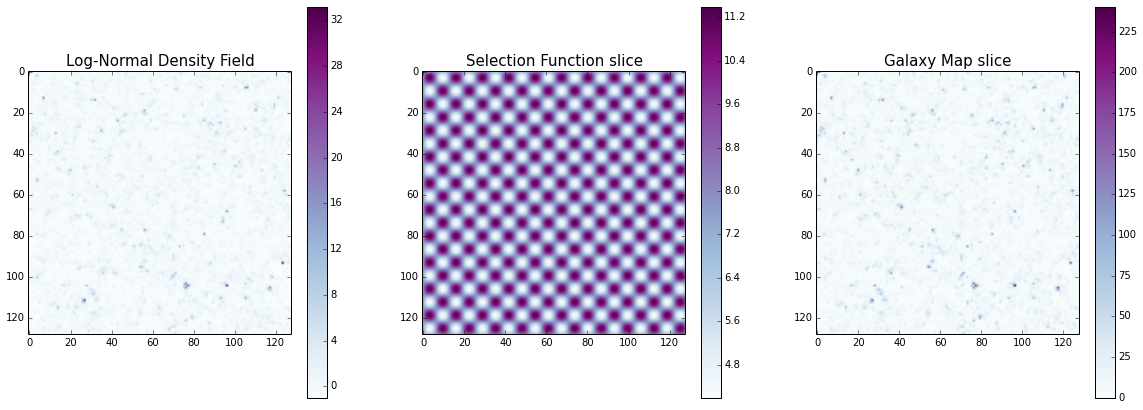

In [19]:
pl.figure(figsize=(20,7),dpi=500)
pl.title("Selection Function: $n(r)=n_0e^{-c.z}(1+C_2\sin (k_0x)\sin (k_0y))$\n,(y,z) slice",fontsize=20)
pl.subplot(1,3,2)
pl.title("Selection Function slice",fontsize=15)
g = 25
#pl.imshow(np.log10(N_r[0,:,0,:]), cmap=cm.jet)
pl.imshow(n_bar_matrix[0,:,:,g], cmap=cm.BuPu)
#pl.imshow(f[:,:,g], cmap=cm.jet)
pl.colorbar()
pl.subplot(1,3,3)
pl.title("Galaxy Map slice", fontsize=15)
pl.imshow(N_r[0,:,:,g], cmap=cm.BuPu)
pl.colorbar()
pl.subplot(1,3,1)
#pl.title("Selection Function (x,y) slice",fontsize=15)
pl.title("Log-Normal Density Field", fontsize=15)
pl.imshow(delta_xr[0,:,:,g], cmap=cm.BuPu)
pl.colorbar()
#pl.subplot(3,3,4)
#pl.plot(grid.grid_r[0,0,:],n_bar_matrix[0,0,:])

#pl.subplot(2,3,3)
#pl.imshow(N_r[2,:,0,:], cmap=cm.jet)
#pl.colorbar()
pl.savefig("selec"+str(file_root)+'.png', transparent=0)

In [20]:
print np.mean(N_r)
print np.max(N_r)
print np.min(N_r)

5.66662836075
1331.0
0.0


In [21]:
fkp_stuff = fkpc.fkp_init(num_bins,n_bar_matrix[0],bias[0],cell_size,n_x,n_y,n_z,MR)
FKP1 = fkp_stuff.fkp(N_r[0])
P_data = fkp_stuff.P_ret.real
Sigma_data = fkp_stuff.sigma.real

0.001


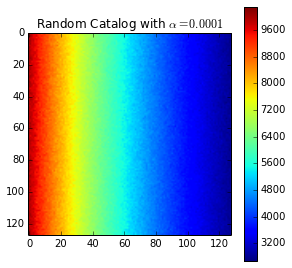

In [25]:
pl.figure(figsize=(10,10))
pl.subplot(2,2,1)
pl.imshow(fkp_stuff.nr[0])
pl.colorbar()
pl.title(r"Random Catalog with $\alpha = 0.0001$")
print fkp_stuff.alpha

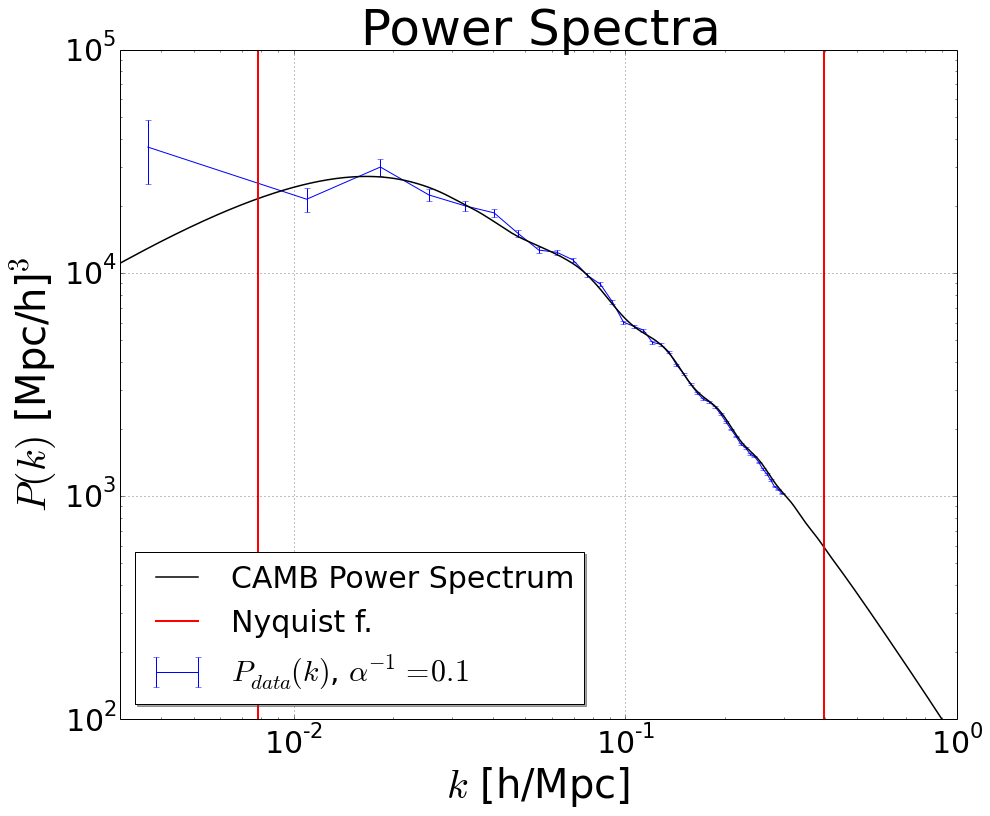

In [26]:
pl.figure('P(k) zoom',figsize=(15,12),dpi=500)
pl.title("Power Spectra",size=50)
#pl.subplot(2,2,1)
pl.loglog()
pl.xlim(3E-3,1.0)
pl.ylim(1E2,1E5)
pl.errorbar(k_bar*(2.*np.pi*n_x/L_x),P_data,yerr=Sigma_data,label=r'$P_{data}(k)$, $\alpha^{-1}=0.1$')#+ " fiducial known n_bar")
#pl.errorbar(k_bar*(2.*np.pi*n_x/L_x),P_data4,yerr=Sigma_data4,label=r'$P_{data}(k)$, $\alpha^{-1}=100.$')#+ " fiducial known n_bar")
#pl.errorbar(k_bar*(2.*np.pi*n_x/L_x),P_data2,yerr=Sigma_data2,label=r'$P_{data}(k)$, $\alpha^{-1} = 10000$' )#+ " fiducial known n_bar")

#pl.errorbar(k_bar*(2.*np.pi*n_x/L_x),0.95*P_av,yerr=P_sig,label='Mean Estimated $P_{data}(k)$, bias = '+str(bias[0]))

#pl.errorbar(k_bar*(2.*np.pi*n_x/L_x),P_data2,yerr=Sigma_data2,label='Mean Estimated $P_{data}(k)$, bias = '+str(bias[1]))

pl.plot(k_camb,Pk_camb, linewidth=1.5,c='k',label="CAMB Power Spectrum")
pl.xlabel(r'$k$ [h/Mpc]',fontsize=40)
pl.xticks(size=30)
pl.yticks(size=30)
pl.ylabel(r'$P(k)$ [Mpc/h]$^3$',fontsize=40)
pl.grid(True)
pl.axvline(x=np.max(np.max(grid.k_x)*(2.*np.pi*n_x/L_x)),linewidth=2.,color='r',label='Nyquist f.')
pl.axvline(x=np.min(grid.grid_k[grid.grid_k!=0.0]), linewidth=2., color='r')
pl.legend(loc=3,prop={'size':30},shadow=1)
pl.savefig("pk.png")


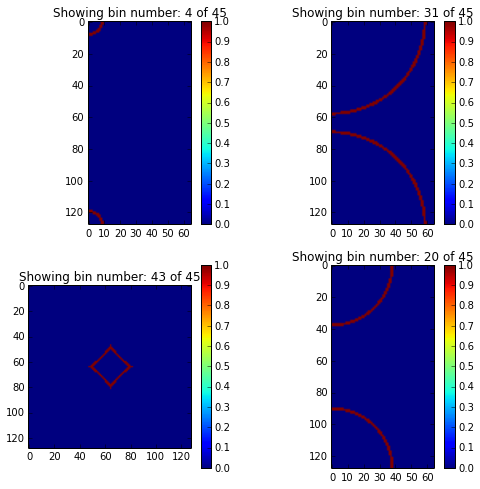

In [24]:
pl.figure("K bins",figsize=(8,8))
pl.subplot(221)
numb =np.random.random_integers(0,num_bins-1)
pl.title("Showing bin number: " + str(numb) + " of " + str(num_bins))
pl.imshow(M[numb,0,:,:])
pl.colorbar()
pl.subplot(222)
numb =np.random.random_integers(0,num_bins-1)
pl.title("Showing bin number: " + str(numb) + " of " + str(num_bins))
pl.imshow(M[numb,:,0,:])
pl.colorbar()
pl.subplot(223)
numb =np.random.random_integers(0,num_bins-1)
pl.title("Showing bin number: " + str(numb) + " of " + str(num_bins))
pl.imshow(M[numb,:,:,0])
pl.colorbar()
pl.subplot(224)
numb =np.random.random_integers(0,num_bins-1)
pl.title("Showing bin number: " + str(numb) + " of " + str(num_bins))
pl.imshow(M[numb,0,:,:])
pl.colorbar()
pl.show()

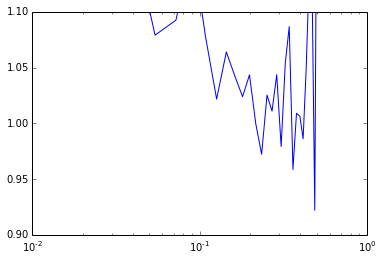

In [28]:
pl.ylim(0.9,1.1)
pl.semilogx((k_bar[1:]+dk_bar[1:]/2)*(2.*np.pi*n_x/L_x),P_data[1:]/pkg.Pk_camb_interp((k_bar[1:]+dk_bar[1:]/2)*(2.*np.pi*n_x/L_x)))
#print P_data/pkg.Pk_camb_interp((k_bar-dk_bar/2)*(2.*np.pi*n_x/L_x))[]

### Trying to estimate $\bar{n}(\vec{r})$

In [19]:
%%time
num_bins2=16
bin_size = (n_x*float(cell_size))/num_bins2
binned_grid = gr.grid3d(num_bins2,num_bins2, num_bins2,bin_size,bin_size,bin_size)
N_bar_bins=np.zeros(((num_bins2,num_bins2,num_bins2)))
#nr_bins=np.zeros(((num_bins2,num_bins2,num_bins2)))
Nx = np.split(N_r[0],num_bins2)
#nrx = np.split(n_bar_matrix[0],num_bins2)
for i in range(len(Nx)):
	Nxy = np.split(Nx[i], num_bins2, axis=1)
	#nrxy = np.split(nrx[i], num_bins2, axis=1)
	for j in range(len(Nxy)):
		Nxyz = np.split(Nxy[j], num_bins2, axis=2)
		#nrxyz = np.split(nrxy[j], num_bins2, axis=2)
		for l in range(len(Nxyz)):
			N_bar_bins[i][j][l] = np.mean(Nxyz[l])#*(cell_size**3.)
			#nr_bins[i][j][l] = np.mean(nrxyz[l])

CPU times: user 231 ms, sys: 4.89 ms, total: 236 ms
Wall time: 238 ms


In [20]:
from scipy.ndimage import map_coordinates
x,y,z = np.mgrid[0:64:64j,0:64:64j,0:64:64j]*cell_size

In [21]:
def map_to_index(x,y,z, bounds, N, M, O):
    xmin,xmax,ymin,ymax,zmin,zmax = bounds
    i1=(x-xmin)/(xmax-xmin)*N
    i2=(y-ymin)/(ymax-ymin)*M
    i3=(z-zmin)/(zmax-zmin)*O
    return i1,i2,i3

In [22]:
i1,i2,i3 = map_to_index(x,y,z,[0,64*cell_size,0,64*cell_size,0,64*cell_size], binned_grid.r_x.shape,binned_grid.r_x.shape,binned_grid.r_x.shape )
N_bbb_real=abs(map_coordinates(N_bar_bins,[i1,i2,i3], order=5,mode='reflect'))*np.exp(1./4)
print N_r.mean()
print n_bar_matrix.mean()
print N_bbb_real.mean()
print N_bbb_real.min()

28.4832572937
28.4971454299
32.695878538
0.1264540731


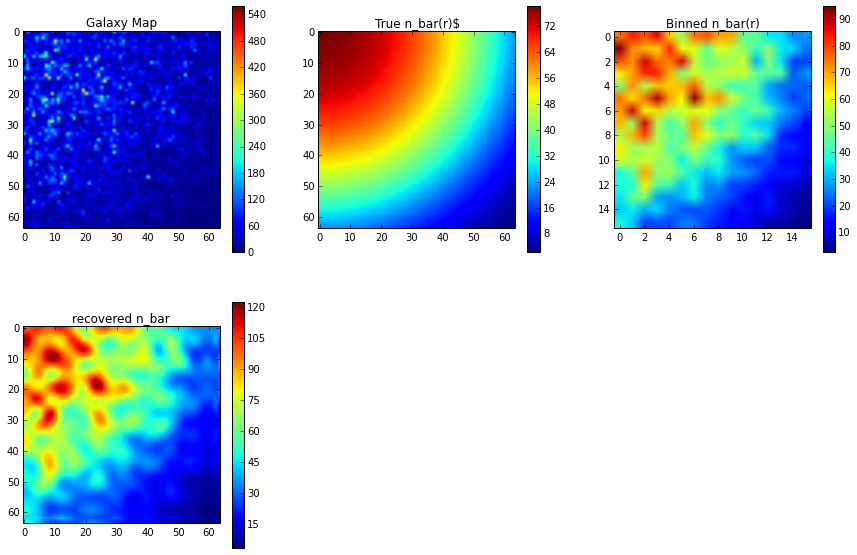

In [23]:
pl.figure(figsize=(15,15))
pl.subplot(3,3,1)
pl.imshow(N_r[0,0])
pl.colorbar()
pl.title("Galaxy Map")
pl.subplot(3,3,2)
pl.imshow(n_bar_matrix[0,0])
pl.colorbar()
pl.title("True n_bar(r)$")
pl.subplot(3,3,3)
pl.imshow(N_bar_bins[0])
pl.colorbar()
pl.title("Binned n_bar(r)")
pl.subplot(3,3,4)
pl.imshow(N_bbb_real[0])
pl.colorbar()
pl.title("recovered n_bar")


In [217]:
fkp_recov = fkpc.fkp_init(num_bins2, N_bbb_real, bias[0], cell_size, n_x,n_y,n_z,M)
FKP2 = fkp_recov.fkp(N_r[0])
P_data2 = fkp_recov.P_ret.real
Sigma_data2 = fkp_recov.sigma.real


[  8.96180488e+05   5.93146417e+01  -2.37647552e+03  -1.01411730e+03
  -4.80391817e+02  -1.56452560e+02  -2.85982338e+01  -4.95858512e+01
  -1.08678182e+02  -1.31867077e+02  -1.13787284e+02  -9.99437503e+01
  -7.46209261e+01  -6.62226598e+01  -5.90880753e+01  -5.41877780e+01
  -4.75835140e+01  -4.36689654e+01  -4.02262413e+01  -3.64421273e+01
  -3.37490307e+01  -3.20404946e+01  -2.85219936e+01  -2.59330371e+01
  -2.44723562e+01  -2.43844098e+01  -2.44224031e+01  -2.55497867e+01
  -2.60478641e+01  -2.73287637e+01  -2.75958194e+01  -2.98817692e+01]


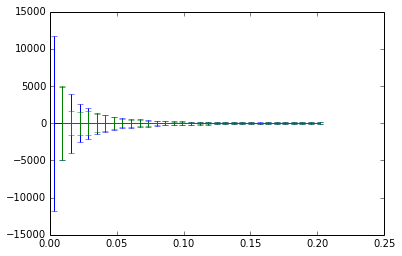

In [219]:
#pl.ylim(-1000,10000)
#pl.loglog()
#pl.plot(Sigma_data2-Sigma_data)
pl.errorbar(k_bar*(2.*np.pi*n_x/L_x),np.zeros_like(k_bar),yerr=Sigma_data)
pl.errorbar(k_bar[1:]*(2.*np.pi*n_x/L_x),np.zeros_like(k_bar)[1:],yerr=Sigma_data2[1:])
print Sigma_data2-Sigma_data